# Protein embeddings improve phage-host interaction prediction

**Mark Edward M. Gonzales<sup>1, 2</sup>, Jennifer C. Ureta<sup>1, 2</sup> & Anish M.S. Shrestha<sup>1, 2</sup>**

<sup>1</sup> Bioinformatics Laboratory, Advanced Research Institute for Informatics, Computing and Networking, De La Salle University, Manila, Philippines <br>
<sup>2</sup> Department of Software Technology, College of Computer Studies, De La Salle University, Manila, Philippines 

{mark_gonzales, jennifer.ureta, anish.shrestha}@dlsu.edu.ph

<hr>

## 💡 Phage-Host-Features CSV Files

This notebook assumes that you already have the phage-host-features CSV files (from running [`5. Data Consolidation.ipynb`](https://github.com/bioinfodlsu/phage-host-prediction/blob/main/experiments/5.%20Data%20Consolidation.ipynb)).

Alternatively, you may download the CSV files from [Google Drive](https://drive.google.com/drive/folders/1xNoA6dxkN4jzVNCg_7YNjdPZzl51Jo9M?usp=sharing) and save the downloaded `data` folder inside the `inphared` directory located in the same folder as this notebook. The folder structure should look like this:

`experiments` (parent folder of this notebook) <br> 
↳ `inphared` <br>
&nbsp; &nbsp;↳ `data` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp.csv` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ `rbp_embeddings_esm.csv` <br>
&nbsp; &nbsp;&nbsp; &nbsp; ↳ ... <br>
↳ `6.1. Additional Model Evaluation (Specificity + PR Curve).ipynb` (this notebook) <br>

This notebook also assumes that you already have the intermediate output files (i.e., those saved in `temp_results`) from running [`6. Classifier Building & Evaluation.ipynb`](https://github.com/bioinfodlsu/phage-host-prediction/blob/main/experiments/6.%20Classifier%20Building%20%26%20Evaluation.ipynb), but these should have already been included when the repository was cloned.

<hr>

## Part I: Preliminaries

Import the necessary libraries and modules.

In [1]:
import math
import pickle
import os
import warnings

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from imblearn.metrics import specificity_score, classification_report_imbalanced
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve

from ConstantsUtil import ConstantsUtil
from ClassificationUtil import ClassificationUtil

%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 50)

pd.options.mode.chained_assignment = None

with warnings.catch_warnings(): 
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [3]:
constants = ConstantsUtil()
util = ClassificationUtil()

<hr>

## Part II: Measuring Specificity

Load the pickled files storing the results of evaluating the performance of the models.

In [4]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))

Declare constant variables for readability of subsequent code.

In [5]:
CLASS = 0
MICRO = 1
MACRO = 2
WEIGHTED = 3

PRECISION = 0
RECALL = 1
F1 = 2
SUPPORT = 3

Y_PROB = -4
Y_TEST = -3
Y_PRED = -1

The shaded cells in the subsequent tables correspond to the highest scores (i.e., best performance in terms of the specified evaluation metric).

### Protein Language Models vs Handcrafted

In [6]:
results = []
for model in models:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[models.index(model)][threshold][Y_TEST]
        y_pred = model_results[models.index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)

print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = models)
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
PROTTRANSBERT,96.89%,96.78%,96.34%,95.83%,95.31%,94.78%,94.08%,93.36%,92.59%,91.64%,89.91%
PROTXLNET,96.82%,96.62%,96.12%,95.64%,95.20%,94.67%,94.04%,93.26%,92.50%,91.52%,89.85%
PROTTRANSALBERT,96.84%,96.76%,96.22%,95.68%,95.20%,94.70%,94.08%,93.30%,92.50%,91.57%,89.82%
PROTT5,97.26%,97.14%,96.60%,96.12%,95.61%,95.08%,94.44%,93.66%,92.93%,91.87%,89.93%
ESM,97.20%,97.00%,96.49%,96.02%,95.54%,95.05%,94.33%,93.60%,92.83%,91.82%,89.96%
ESM1B,97.33%,97.07%,96.61%,96.07%,95.57%,95.01%,94.35%,93.60%,92.83%,91.81%,89.94%
SEQVEC,96.63%,96.65%,96.19%,95.71%,95.24%,94.73%,94.06%,93.29%,92.56%,91.56%,89.76%
BOECKAERTS,96.76%,96.81%,96.32%,95.77%,95.17%,94.58%,93.89%,93.10%,92.36%,91.41%,89.61%


In [7]:
print("Weighted Specificity per Class")
print("\n============\n")

model = 'PROTT5'
for threshold in range(0, 11):
    print('Confidence Threshold k:', str(threshold * 10) + '%')
    y_test = model_results[models.index(model)][threshold][Y_TEST]
    y_pred = model_results[models.index(model)][threshold][Y_PRED]
    
    print()
    print(classification_report_imbalanced(y_test, y_pred, digits = 4, zero_division = 0))
    print("\n============\n")

Weighted Specificity per Class


Confidence Threshold k: 0%

                         pre       rec       spe        f1       geo       iba       sup

    achromobacter     0.9000    0.5294    0.9999    0.6667    0.7276    0.5044        17
    acinetobacter     0.9565    0.6735    0.9996    0.7904    0.8205    0.6513        98
        aeromonas     0.8267    0.6526    0.9984    0.7294    0.8072    0.6290        95
    agrobacterium     0.8333    0.4167    0.9999    0.5556    0.6455    0.3923        12
     arthrobacter     0.8333    0.7692    0.9995    0.8000    0.8768    0.7511        26
         bacillus     0.8128    0.8725    0.9948    0.8416    0.9317    0.8574       204
      bacteroides     0.9032    0.9032    0.9996    0.9032    0.9502    0.8942        31
    brevundimonas     1.0000    0.6000    1.0000    0.7500    0.7746    0.5760        10
     burkholderia     0.6452    0.5128    0.9986    0.5714    0.7156    0.4872        39
    campylobacter     0.8655    0.8306    0.9980

                         pre       rec       spe        f1       geo       iba       sup

    achromobacter     1.0000    0.2941    1.0000    0.4545    0.5423    0.2734        17
    acinetobacter     1.0000    0.5510    1.0000    0.7105    0.7423    0.5263        98
        aeromonas     0.9623    0.5368    0.9998    0.6892    0.7326    0.5119        95
    agrobacterium     1.0000    0.3333    1.0000    0.5000    0.5774    0.3111        12
     arthrobacter     1.0000    0.6538    1.0000    0.7907    0.8086    0.6312        26
         bacillus     0.9425    0.8039    0.9987    0.8677    0.8960    0.7873       204
      bacteroides     1.0000    0.7742    1.0000    0.8727    0.8799    0.7567        31
    brevundimonas     1.0000    0.5000    1.0000    0.6667    0.7071    0.4750        10
     burkholderia     0.9333    0.3590    0.9999    0.5185    0.5991    0.3359        39
    campylobacter     0.8889    0.7742    0.9985    0.8276    0.8792    0.7557       124
      caulobacter   

                         pre       rec       spe        f1       geo       iba       sup

    achromobacter     1.0000    0.2941    1.0000    0.4545    0.5423    0.2734        17
    acinetobacter     1.0000    0.4388    1.0000    0.6099    0.6624    0.4142        98
        aeromonas     0.9722    0.3684    0.9999    0.5344    0.6069    0.3451        95
    agrobacterium     1.0000    0.3333    1.0000    0.5000    0.5774    0.3111        12
     arthrobacter     1.0000    0.6538    1.0000    0.7907    0.8086    0.6312        26
         bacillus     0.9603    0.7108    0.9992    0.8169    0.8428    0.6898       204
      bacteroides     1.0000    0.7097    1.0000    0.8302    0.8424    0.6891        31
    brevundimonas     1.0000    0.3000    1.0000    0.4615    0.5477    0.2790        10
     burkholderia     1.0000    0.2564    1.0000    0.4082    0.5064    0.2373        39
    campylobacter     0.9271    0.7177    0.9991    0.8091    0.8468    0.6969       124
      caulobacter   

                         pre       rec       spe        f1       geo       iba       sup

    achromobacter     1.0000    0.1176    1.0000    0.2105    0.3430    0.1073        17
    acinetobacter     1.0000    0.3163    1.0000    0.4806    0.5624    0.2947        98
        aeromonas     1.0000    0.2316    1.0000    0.3761    0.4812    0.2138        95
    agrobacterium     1.0000    0.3333    1.0000    0.5000    0.5774    0.3111        12
     arthrobacter     1.0000    0.5000    1.0000    0.6667    0.7071    0.4750        26
         bacillus     0.9638    0.6520    0.9994    0.7778    0.8072    0.6289       204
      bacteroides     1.0000    0.5806    1.0000    0.7347    0.7620    0.5563        31
    brevundimonas     1.0000    0.2000    1.0000    0.3333    0.4472    0.1840        10
     burkholderia     1.0000    0.1282    1.0000    0.2273    0.3581    0.1170        39
    campylobacter     0.9610    0.5968    0.9996    0.7363    0.7724    0.5725       124
      caulobacter   

                         pre       rec       spe        f1       geo       iba       sup

    achromobacter     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        17
    acinetobacter     1.0000    0.1633    1.0000    0.2807    0.4041    0.1496        98
        aeromonas     1.0000    0.1158    1.0000    0.2075    0.3403    0.1056        95
    agrobacterium     1.0000    0.2500    1.0000    0.4000    0.5000    0.2313        12
     arthrobacter     1.0000    0.2692    1.0000    0.4242    0.5189    0.2496        26
         bacillus     0.9802    0.4853    0.9997    0.6492    0.6965    0.4602       204
      bacteroides     1.0000    0.2903    1.0000    0.4500    0.5388    0.2697        31
    brevundimonas     1.0000    0.1000    1.0000    0.1818    0.3162    0.0910        10
     burkholderia     1.0000    0.0769    1.0000    0.1429    0.2774    0.0698        39
    campylobacter     1.0000    0.3710    1.0000    0.5412    0.6091    0.3476       124
      caulobacter   

                         pre       rec       spe        f1       geo       iba       sup

    achromobacter     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        17
    acinetobacter     1.0000    0.0102    1.0000    0.0202    0.1010    0.0092        98
        aeromonas     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        95
    agrobacterium     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        12
     arthrobacter     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        26
         bacillus     1.0000    0.0490    1.0000    0.0935    0.2214    0.0444       204
      bacteroides     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        31
    brevundimonas     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        10
     burkholderia     0.0000    0.0000    1.0000    0.0000    0.0000    0.0000        39
    campylobacter     1.0000    0.0484    1.0000    0.0923    0.2200    0.0438       124
      caulobacter   

### Global: ProtT5 + Handcrafted (Individually)

In [8]:
model_results = []
important_features = ['A_freq', 'GC', 'C_freq', 'TTA', 'TTA_b']
for model in important_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [9]:
results = []
for model in important_features[:5]:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[important_features[:5].index(model)][threshold][Y_TEST]
        y_pred = model_results[important_features[:5].index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = important_features[:5])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
A_freq,97.38%,97.20%,96.67%,96.17%,95.70%,95.17%,94.51%,93.76%,93.00%,91.90%,89.93%
GC,97.31%,97.21%,96.70%,96.21%,95.72%,95.21%,94.57%,93.80%,93.01%,91.97%,90.01%
C_freq,97.27%,97.18%,96.73%,96.21%,95.74%,95.24%,94.53%,93.78%,92.99%,91.92%,89.95%
TTA,97.31%,97.13%,96.60%,96.13%,95.64%,95.13%,94.48%,93.67%,92.90%,91.87%,89.94%
TTA_b,97.28%,97.13%,96.62%,96.14%,95.60%,95.12%,94.47%,93.67%,92.89%,91.86%,89.92%


### Protein Features Only: ProtT5 + Handcrafted (Individually)

In [10]:
model_results = []
important_protein_features = ['K', 'pI', 'Z4', 'CTDC2', 'mol_weight']
for model in important_protein_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [11]:
results = []
for model in important_protein_features[:5]:
    result = []
    for threshold in range(0, 11):
        y_test = model_results[important_protein_features[:5].index(model)][threshold][Y_TEST]
        y_pred = model_results[important_protein_features[:5].index(model)][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = important_protein_features[:5])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
K,97.22%,97.13%,96.62%,96.16%,95.64%,95.12%,94.44%,93.65%,92.94%,91.89%,89.94%
pI,97.20%,97.13%,96.60%,96.13%,95.61%,95.09%,94.43%,93.63%,92.91%,91.86%,89.98%
Z4,97.18%,97.13%,96.58%,96.14%,95.66%,95.11%,94.43%,93.64%,92.88%,91.87%,89.94%
CTDC2,97.20%,97.14%,96.62%,96.14%,95.63%,95.13%,94.42%,93.67%,92.90%,91.85%,89.99%
mol_weight,97.22%,97.12%,96.58%,96.14%,95.65%,95.07%,94.45%,93.68%,92.91%,91.85%,89.96%


### Global: ProtT5 + Handcrafted (Top n)

In [12]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [13]:
results = []
for i in range(1, 6):
    result = []
    for threshold in range(0, 11):
        y_test = model_results[i - 1][threshold][Y_TEST]
        y_pred = model_results[i - 1][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)
        
        result.append(f'{metric}%')

    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = [i for i in range(1, 6)])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
1,97.38%,97.20%,96.67%,96.17%,95.70%,95.17%,94.51%,93.76%,93.00%,91.90%,89.93%
2,97.36%,97.20%,96.75%,96.27%,95.75%,95.28%,94.61%,93.83%,93.01%,91.94%,89.96%
3,97.37%,97.18%,96.72%,96.27%,95.76%,95.26%,94.60%,93.84%,93.03%,91.99%,89.96%
4,97.37%,97.23%,96.74%,96.26%,95.80%,95.30%,94.59%,93.83%,93.02%,91.96%,89.88%
5,97.37%,97.20%,96.74%,96.30%,95.78%,95.30%,94.59%,93.81%,93.03%,91.99%,89.93%


### Protein Features Only: ProtT5 + Handcrafted (Top n)

In [14]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_protein_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [15]:
results = []
for i in range(1, 6):
    result = []
    for threshold in range(0, 11):
        y_test = model_results[i - 1][threshold][Y_TEST]
        y_pred = model_results[i - 1][threshold][Y_PRED]
        metric = "{:.2f}".format(specificity_score(y_test, y_pred, average='weighted') * 100)

        result.append(f'{metric}%')
        
    results.append(result)
        
print("Weighted Specificity")
results_df = pd.DataFrame(results, columns = [str(_) + '%' for _ in range(0, 101, 10)], index = [i for i in range(1, 6)])
results_df.style.highlight_max(color = 'lightgreen', axis = 0)

Weighted Specificity


,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
1,97.22%,97.13%,96.62%,96.16%,95.64%,95.12%,94.44%,93.65%,92.94%,91.89%,89.94%
2,97.27%,97.17%,96.63%,96.13%,95.65%,95.09%,94.45%,93.67%,92.91%,91.86%,89.96%
3,97.19%,97.14%,96.63%,96.14%,95.61%,95.11%,94.44%,93.65%,92.86%,91.87%,89.97%
4,97.19%,97.14%,96.62%,96.17%,95.66%,95.11%,94.45%,93.67%,92.90%,91.91%,89.98%
5,97.22%,97.09%,96.64%,96.14%,95.62%,95.10%,94.41%,93.69%,92.92%,91.86%,89.92%


<hr>

## Part II: Plotting the PR Curve

### Protein Language Models vs Handcrafted

In [16]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))

In [17]:
results_precision = []
for model in models:
    result = []
    for threshold in range(0, 11):
        metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
results_recall = []
for model in models:
    result = []
    for threshold in range(0, 11):
        metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

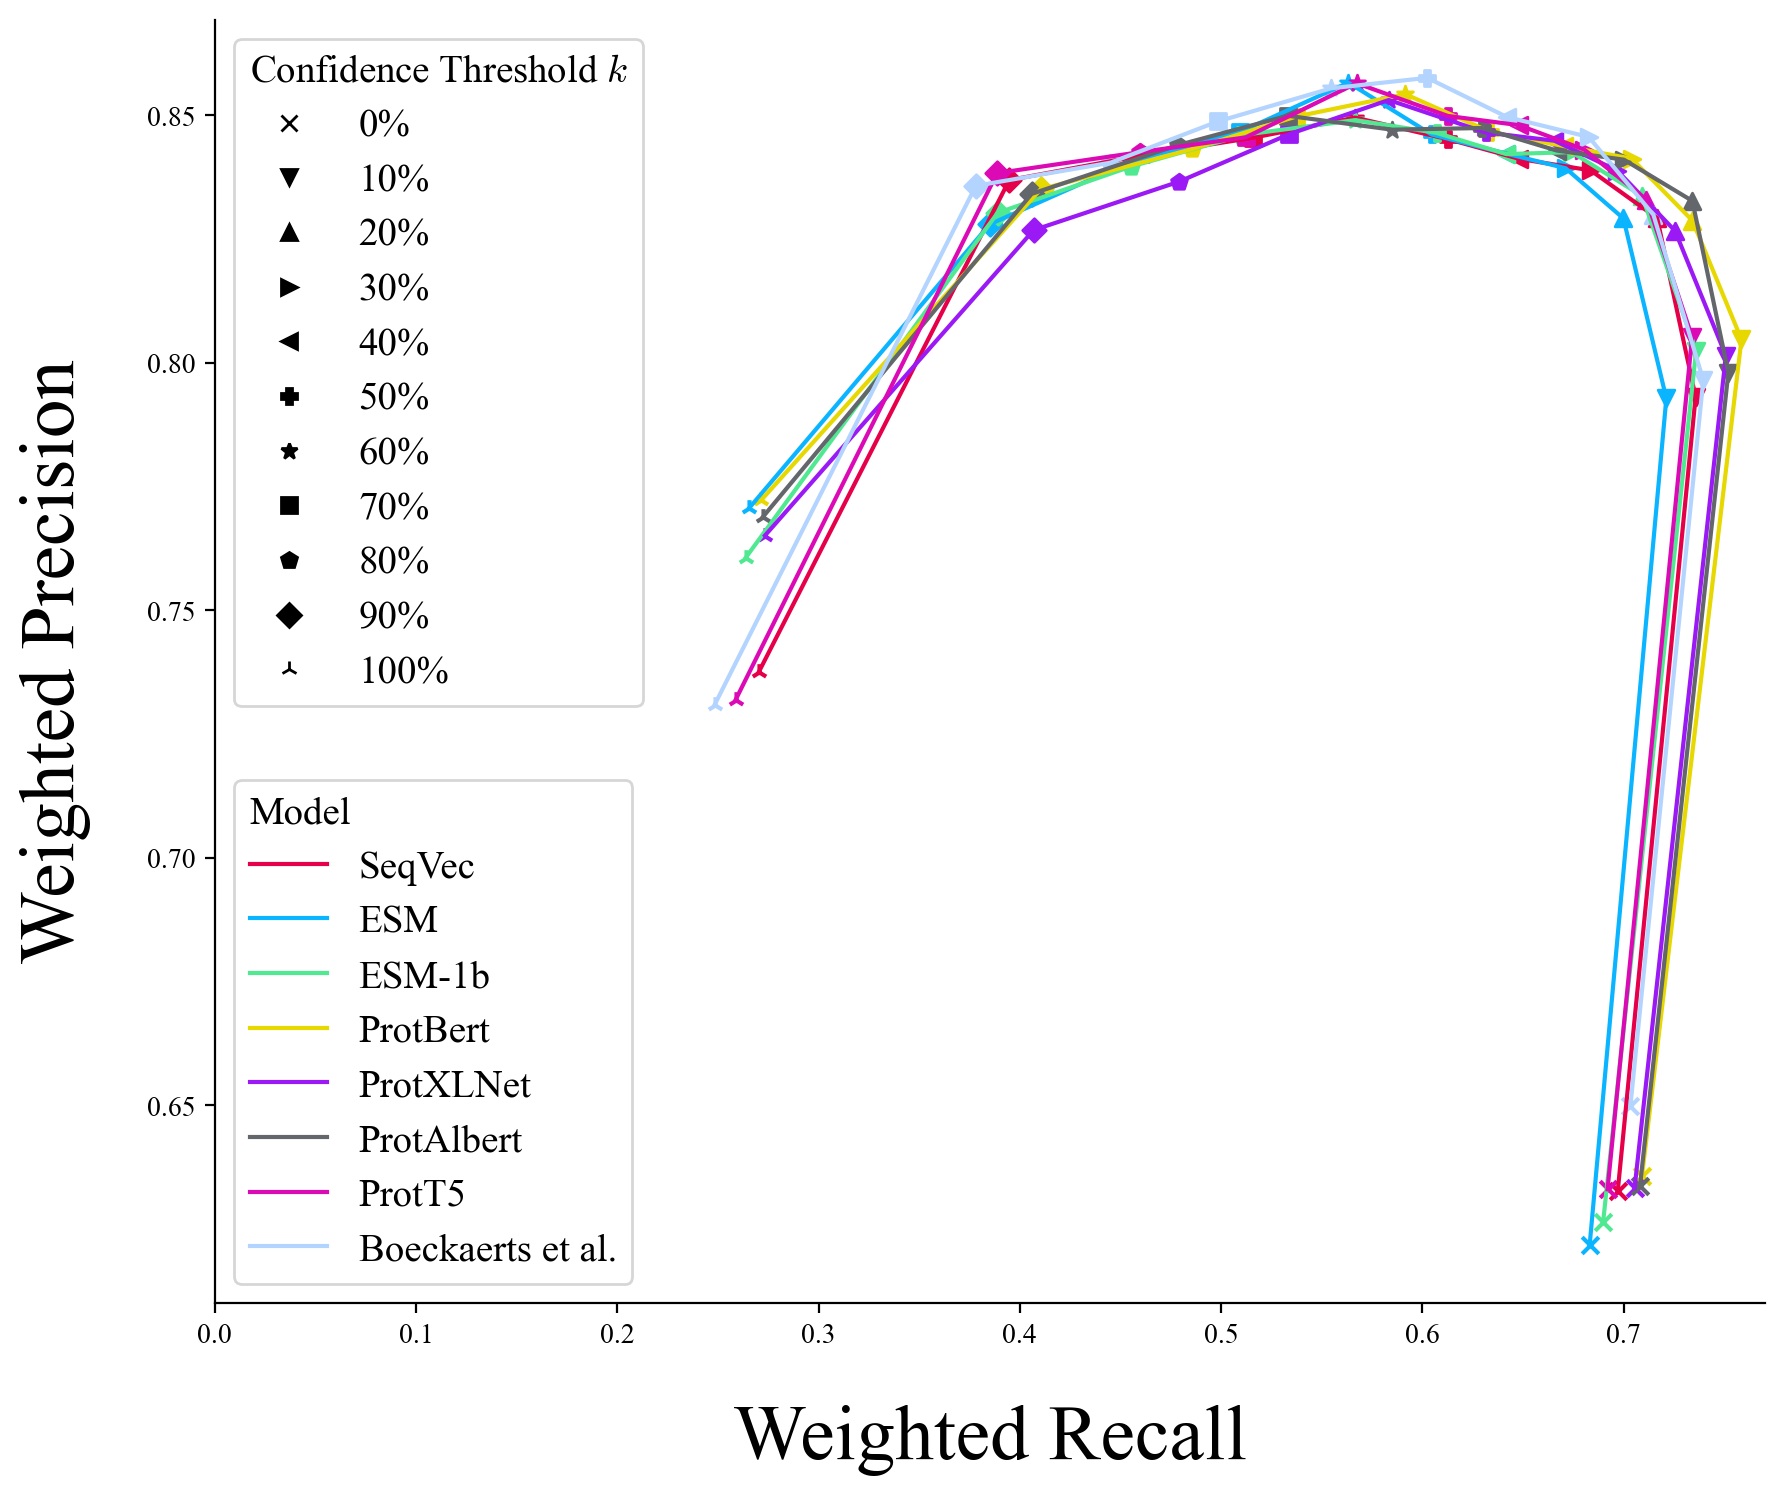

In [18]:
from matplotlib.lines import Line2D

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['legend.title_fontsize'] = '14'

fig, ax = plt.subplots(figsize=(10, 8.5), dpi=200)

colors = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#63666a", "#dc0ab4", "#b3d4ff", "#00bfa0"]
markers = ['x', 'v', '^', '>', '<', 'P', '*', 's', 'p', 'D', '2']
k = [str(i) + '%' for i in range(0, 101, 10)]

marker_handles = [Line2D([0], [0], marker = m, label = lbl, lw = 0, markerfacecolor = 'black',
                         markeredgecolor = 'black') for m, lbl in zip(markers, k)]

for i in range(len(models)):
    for j in range(0, 11):
        ax.scatter(results_recall[i][j], results_precision[i][j], color = colors[i], marker = markers[j])

line0, = ax.plot(results_recall[0], results_precision[0], color = colors[0], label = 'SeqVec')
line1, = ax.plot(results_recall[1], results_precision[1], color = colors[1], label = 'ESM')
line2, = ax.plot(results_recall[2], results_precision[2], color = colors[2], label = 'ESM-1b')
line3, = ax.plot(results_recall[3], results_precision[3], color = colors[3], label = 'ProtBert')
line4, = ax.plot(results_recall[4], results_precision[4], color = colors[4], label = 'ProtXLNet')
line5, = ax.plot(results_recall[5], results_precision[5], color = colors[5], label = 'ProtAlbert')
line6, = ax.plot(results_recall[6], results_precision[6], color = colors[6], label = 'ProtT5')
line7, = ax.plot(results_recall[7], results_precision[7], color = colors[7], label = 'Boeckaerts et al.')

ax.set_xlim(xmin=0, xmax=0.77)
ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
legend1 = ax.legend(loc = 'lower left', 
                    handles = [line0, line1, line2, line3, line4, line5, line6, line7],
                    prop={'size': 14},
                    title = 'Model')
legend2 = ax.legend(loc = 'upper left', 
                    handles = marker_handles,
                    prop={'size': 14},
                    title = 'Confidence Threshold $k$')

legend1._legend_box.align = "left"
legend2._legend_box.align = "left"
plt.gca().add_artist(legend1)

### Confidence Threshold $k$ = 0

In [19]:
_, y_train, _, y_test = util.get_train_test_sets()

Constructing training and test sets...


In [20]:
label_binarizer = LabelBinarizer().fit(np.insert(y_train.values, 0, 'others'))
y_test_onehot = label_binarizer.transform(y_test)
n_classes = len(np.unique(y_test))

In [21]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))

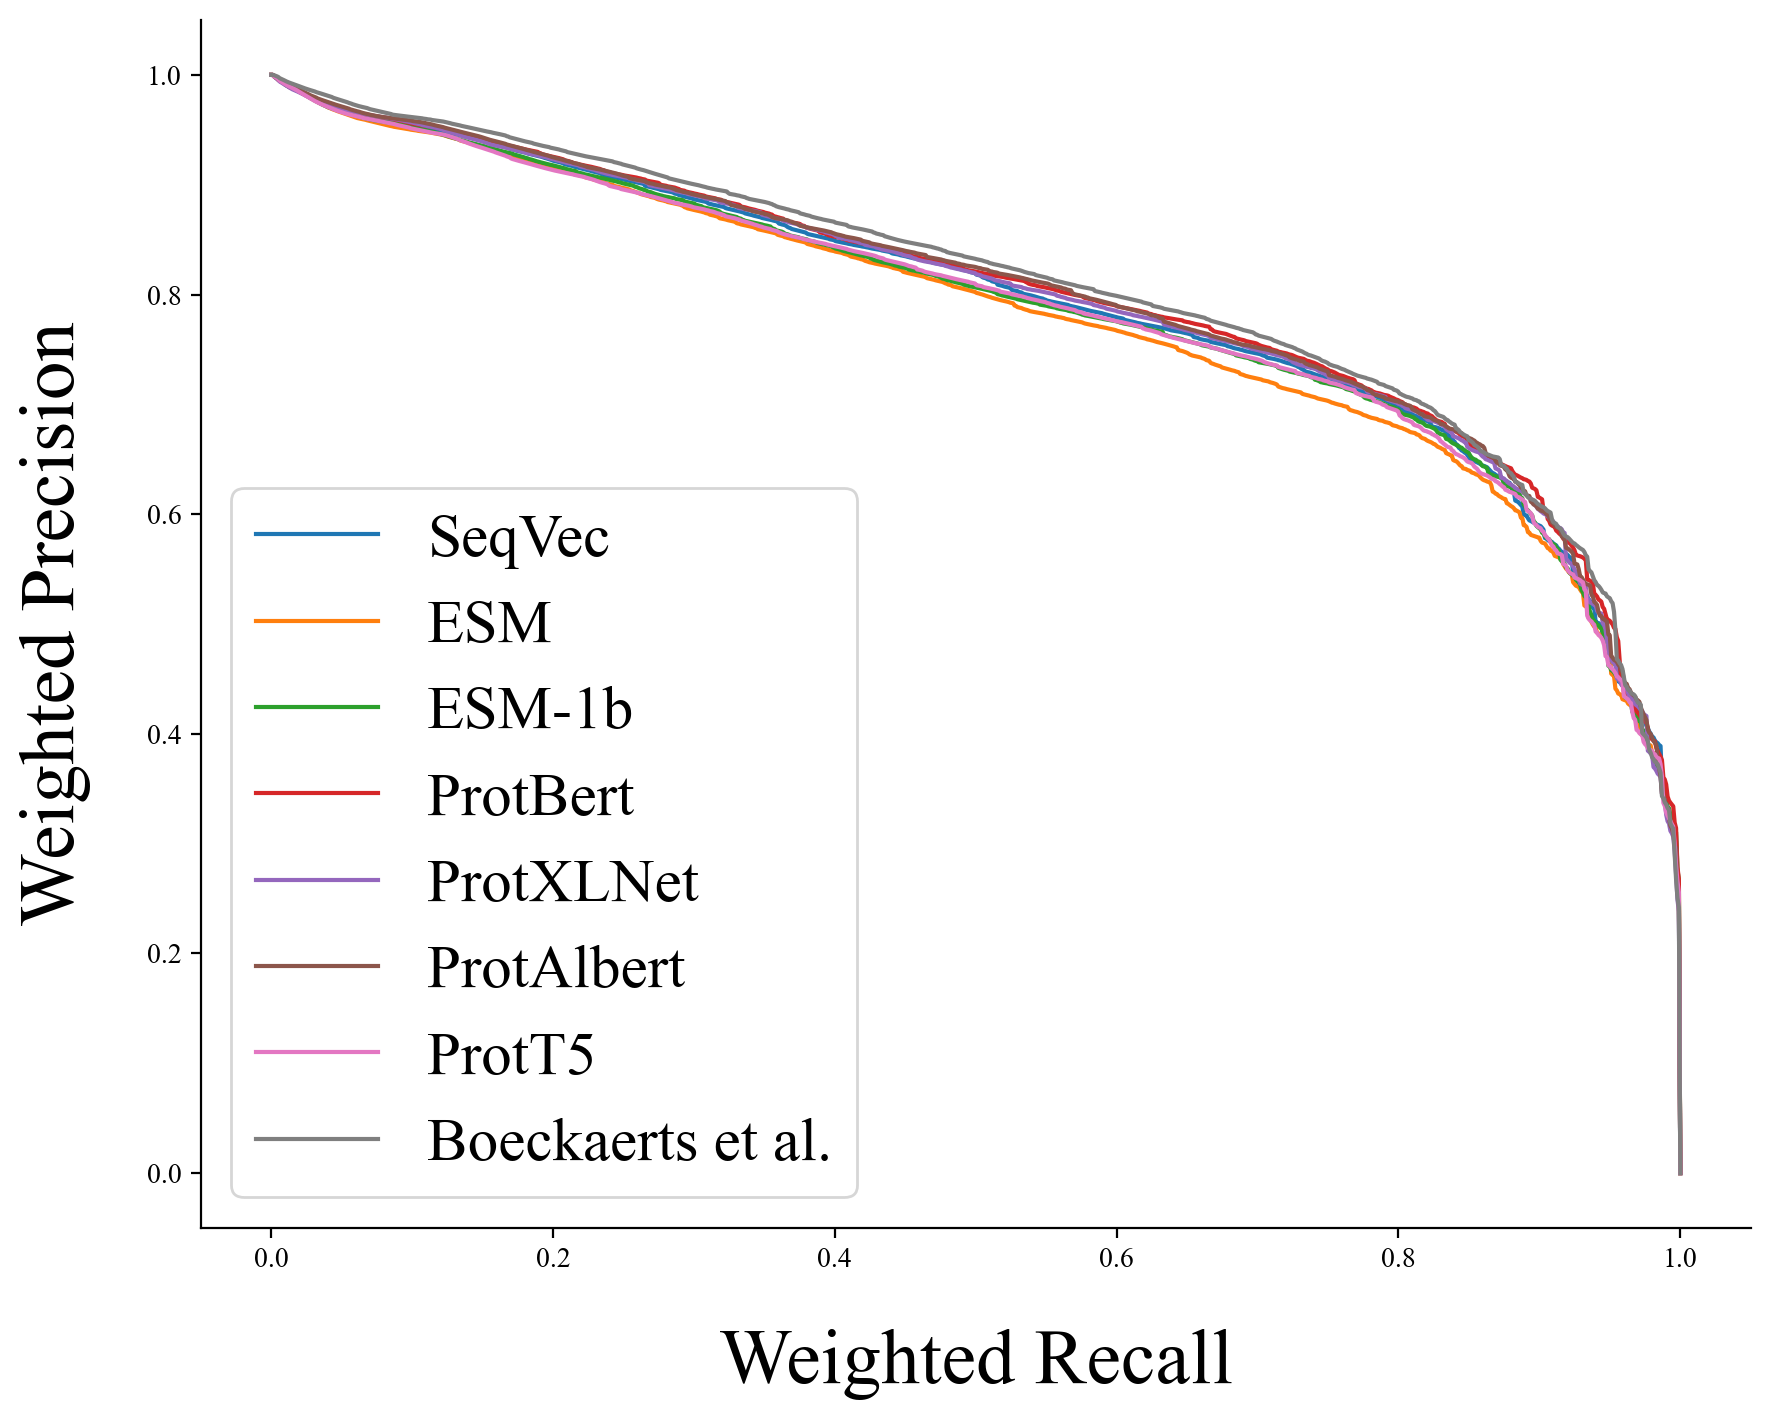

In [22]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)

models = ['SEQVEC', 'ESM', 'ESM1B', 'PROTTRANSBERT', 'PROTXLNET', 'PROTTRANSALBERT', 'PROTT5', 'BOECKAERTS']

for model in models:
    y_prob = model_results[models.index(model)][0][Y_PROB]
    support = model_results[models.index(model)][0][CLASS][SUPPORT]
    y_prob = np.insert(y_prob, np.where(np.unique(y_test) == 'others')[0][0], 0, axis = 1)

    precision = {}
    recall = {}
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_onehot[:, i], y_prob[:, i])

    recall_grid = np.linspace(0.0, 1.0, 1000)
    mean_precision = np.zeros_like(recall_grid)
    for i in range(n_classes):
        mean_precision += np.interp(recall_grid, precision[i], recall[i]) * support[i]

    mean_precision = mean_precision / sum(support)

    precision['weighted'] = mean_precision
    recall['weighted'] = recall_grid

    ax.plot(recall['weighted'], precision['weighted'])
    
ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
legend = ax.legend(['SeqVec', 
                    'ESM', 
                    'ESM-1b', 
                    'ProtBert', 
                    'ProtXLNet', 
                    'ProtAlbert', 
                    'ProtT5', 
                    'Boeckaerts et al.'], loc = 'lower left',
                   prop = {'size': 22})

### Global: ProtT5 + Handcrafted (Individually)

In [23]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [24]:
model_results = []
for model in important_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [25]:
for model in important_features[:5]:
    result = []
    for threshold in range(0, 11):
        metric = model_results[important_features[:5].index(model)][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for model in important_features[:5]:
    result = []
    for threshold in range(0, 11):
        metric = model_results[important_features[:5].index(model)][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

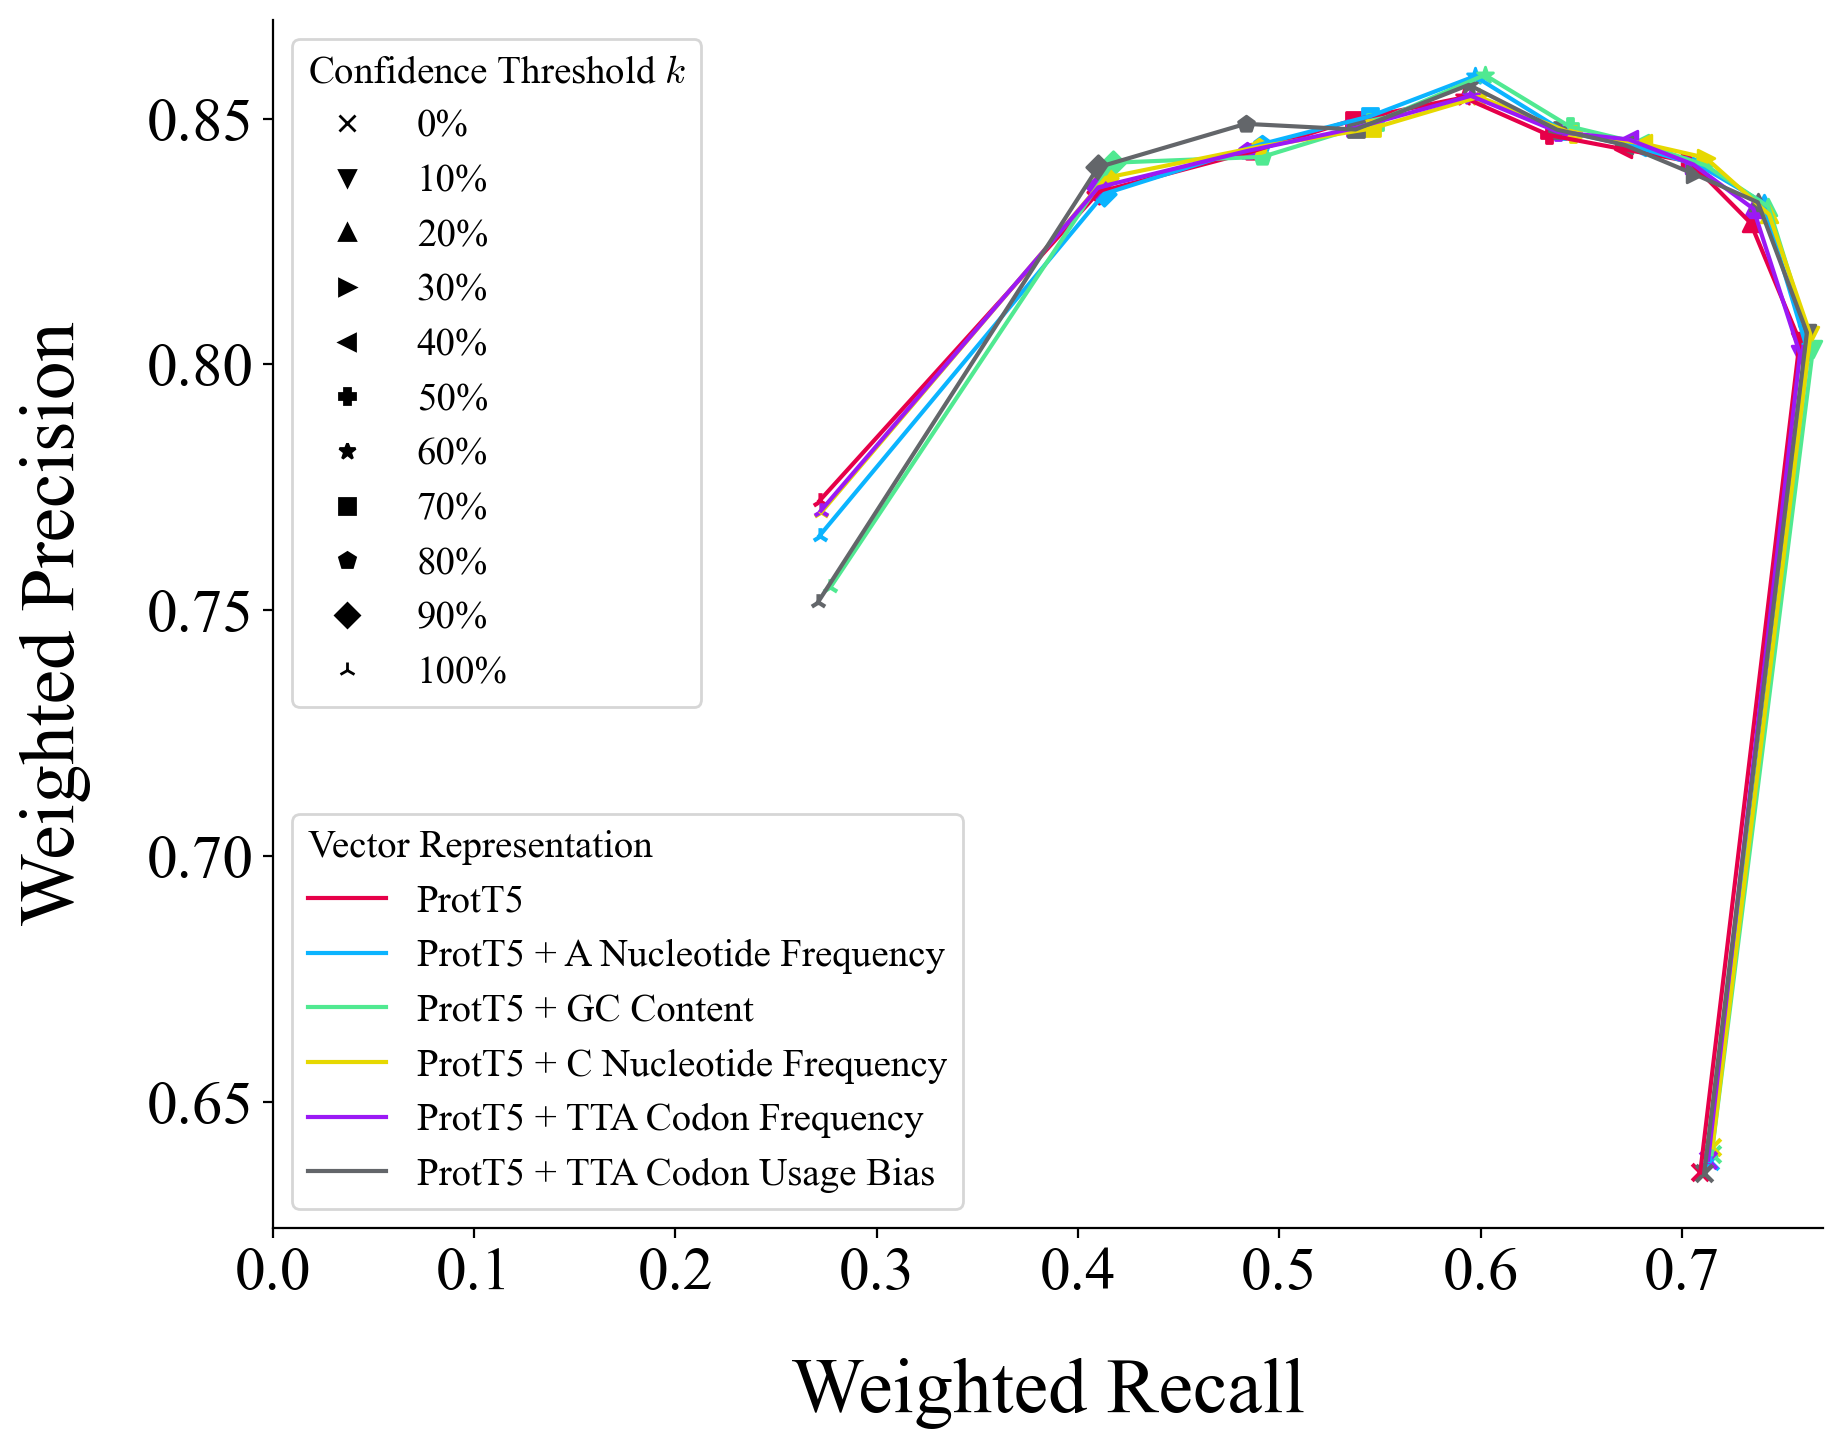

In [26]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)

line0, = ax.plot(results_recall[0], results_precision[0], color = colors[0], label = 'ProtT5')
line1, = ax.plot(results_recall[1], results_precision[1], color = colors[1], label = 'ProtT5 + A Nucleotide Frequency')
line2, = ax.plot(results_recall[2], results_precision[2], color = colors[2], label = 'ProtT5 + GC Content')
line3, = ax.plot(results_recall[3], results_precision[3], color = colors[3], label = 'ProtT5 + C Nucleotide Frequency')
line4, = ax.plot(results_recall[4], results_precision[4], color = colors[4], label = 'ProtT5 + TTA Codon Frequency')
line5, = ax.plot(results_recall[5], results_precision[5], color = colors[5], label = 'ProtT5 + TTA Codon Usage Bias')

for i in range(0, 6):
    for j in range(0, 11):
        ax.scatter(results_recall[i][j], results_precision[i][j], color = colors[i], marker = markers[j])

ax.set_xlim(xmin=0, xmax=0.77)
ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
legend1 = ax.legend(loc = 'lower left', 
                    handles = [line0, line1, line2, line3, line4, line5],
                    prop={'size': 14},
                    title = 'Vector Representation')
legend2 = ax.legend(loc = 'upper left', 
                    handles = marker_handles,
                    prop={'size': 14},
                    title = 'Confidence Threshold $k$')

legend1._legend_box.align = "left"
legend2._legend_box.align = "left"
plt.gca().add_artist(legend1)

### Protein Features Only: ProtT5 + Handcrafted (Individually)

In [27]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [28]:
model_results = []
for model in important_protein_features[:5]:
    with open(f'{constants.TEMP_RESULTS}/prott5_{model}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [29]:
for model in important_protein_features[:5]:
    result = []
    for threshold in range(0, 11):
        metric = model_results[important_protein_features[:5].index(model)][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for model in important_protein_features[:5]:
    result = []
    for threshold in range(0, 11):
        metric = model_results[important_protein_features[:5].index(model)][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

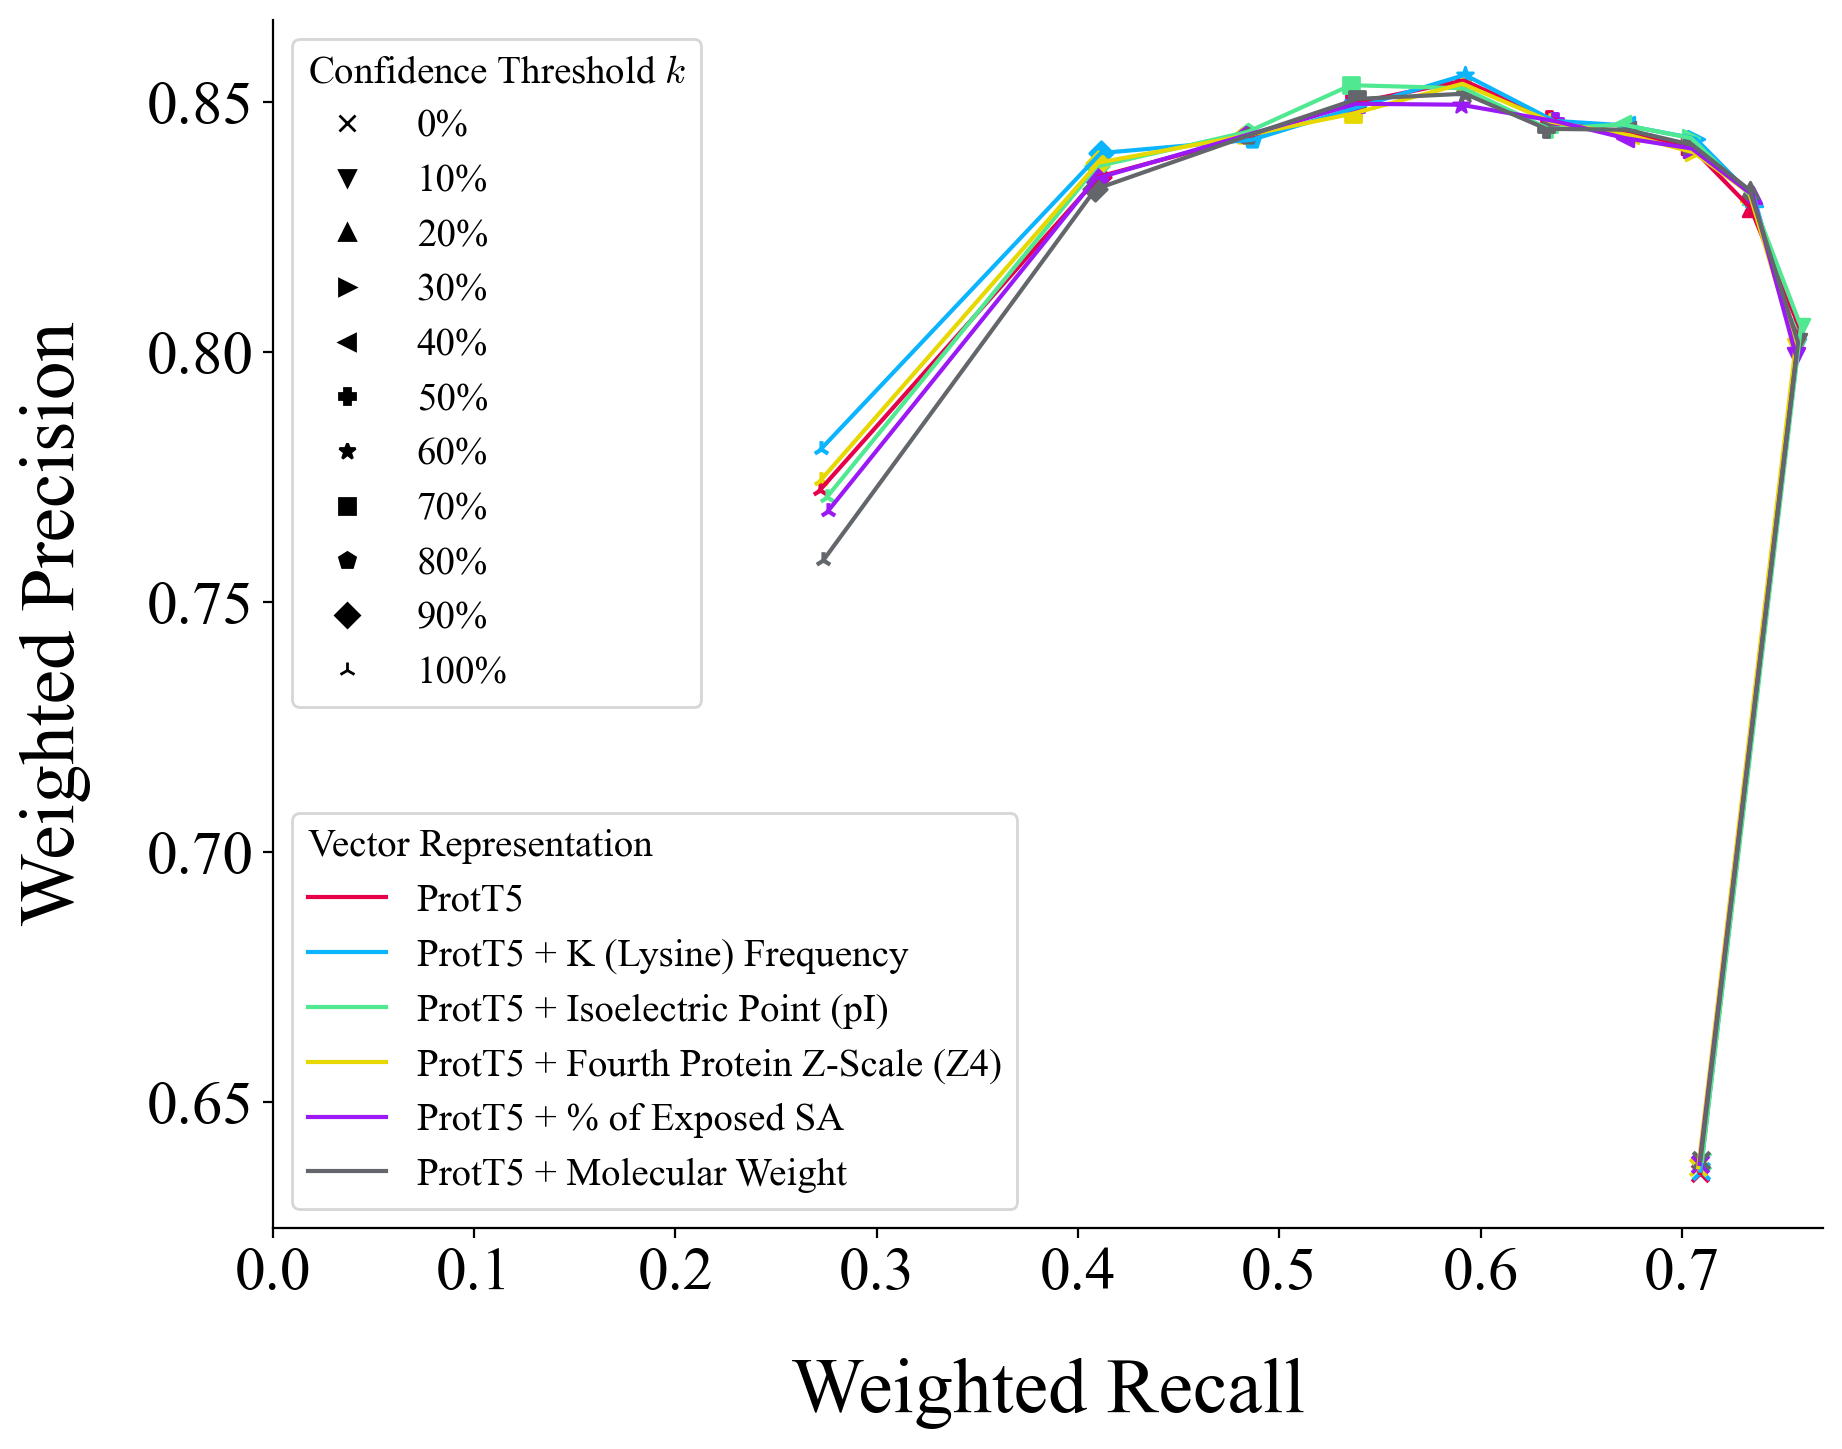

In [30]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)

line0, = ax.plot(results_recall[0], results_precision[0], color = colors[0], label = 'ProtT5')
line1, = ax.plot(results_recall[1], results_precision[1], color = colors[1], label = 'ProtT5 + K (Lysine) Frequency')
line2, = ax.plot(results_recall[2], results_precision[2], color = colors[2], label = 'ProtT5 + Isoelectric Point (pI)')
line3, = ax.plot(results_recall[3], results_precision[3], color = colors[3], label = 'ProtT5 + Fourth Protein Z-Scale (Z4)')
line4, = ax.plot(results_recall[4], results_precision[4], color = colors[4], label = 'ProtT5 + % of Exposed SA')
line5, = ax.plot(results_recall[5], results_precision[5], color = colors[5], label = 'ProtT5 + Molecular Weight')

for i in range(0, 6):
    for j in range(0, 11):
        ax.scatter(results_recall[i][j], results_precision[i][j], color = colors[i], marker = markers[j])

ax.set_xlim(xmin=0, xmax=0.77)
ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
legend1 = ax.legend(loc = 'lower left', 
                    handles = [line0, line1, line2, line3, line4, line5],
                    prop={'size': 14},
                    title = 'Vector Representation')
legend2 = ax.legend(loc = 'upper left', 
                    handles = marker_handles,
                    prop={'size': 14},
                    title = 'Confidence Threshold $k$')

legend1._legend_box.align = "left"
legend2._legend_box.align = "left"
plt.gca().add_artist(legend1)

### Global: ProtT5 + Handcrafted (Top n)

In [31]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [32]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [33]:
for i in range(0, 5):
    result = []
    for threshold in range(0, 11):
        metric = model_results[i][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for i in range(0, 5):
    result = []
    for threshold in range(0, 11):
        metric = model_results[i][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

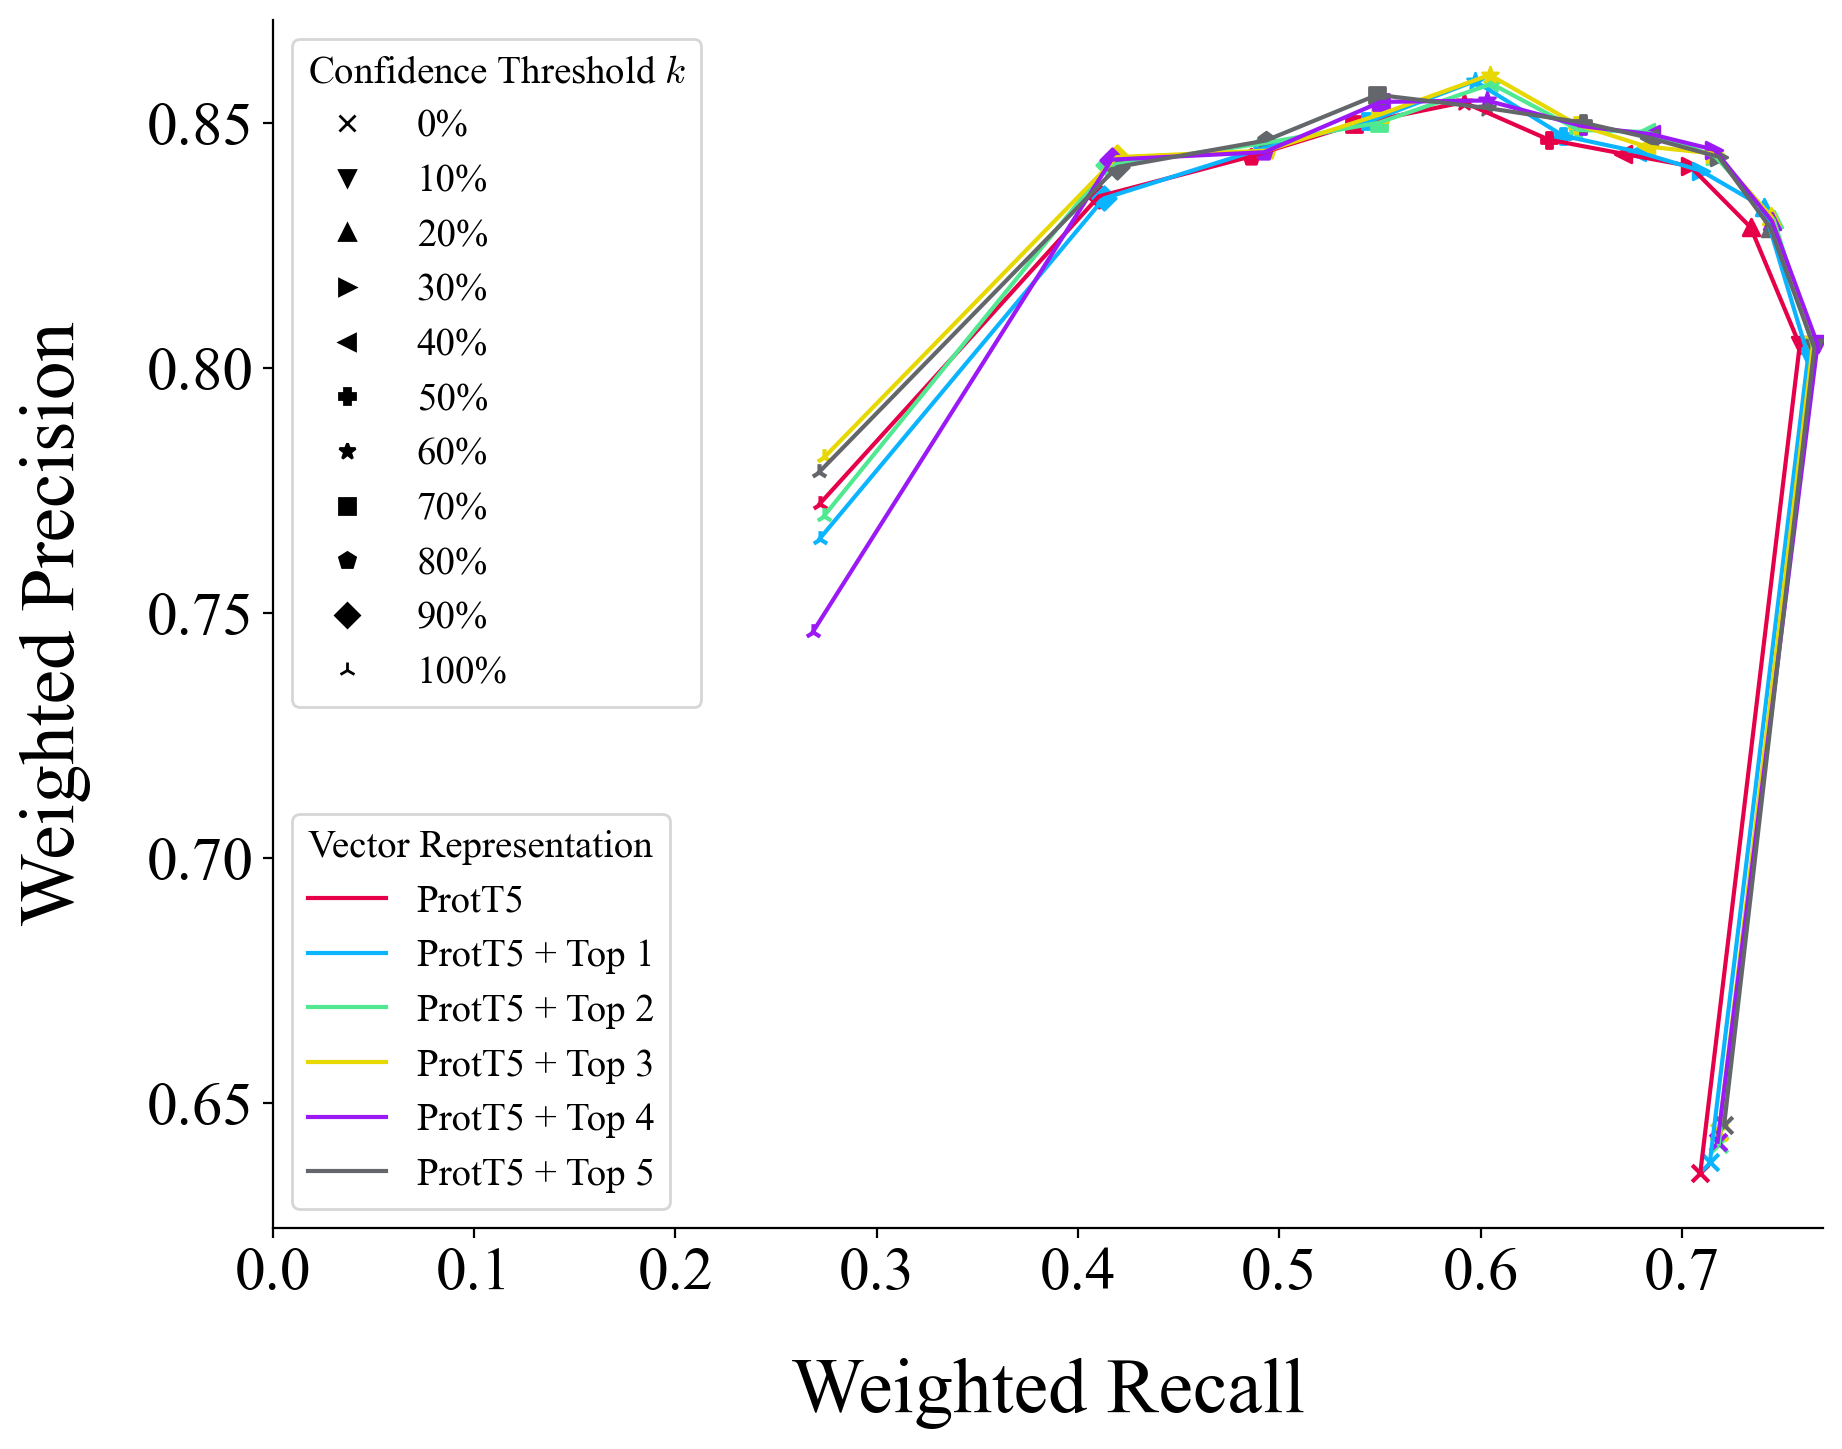

In [34]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)

line0, = ax.plot(results_recall[0], results_precision[0], color = colors[0], label = 'ProtT5')
line1, = ax.plot(results_recall[1], results_precision[1], color = colors[1], label = 'ProtT5 + Top 1')
line2, = ax.plot(results_recall[2], results_precision[2], color = colors[2], label = 'ProtT5 + Top 2')
line3, = ax.plot(results_recall[3], results_precision[3], color = colors[3], label = 'ProtT5 + Top 3')
line4, = ax.plot(results_recall[4], results_precision[4], color = colors[4], label = 'ProtT5 + Top 4')
line5, = ax.plot(results_recall[5], results_precision[5], color = colors[5], label = 'ProtT5 + Top 5')

for i in range(0, 6):
    for j in range(0, 11):
        ax.scatter(results_recall[i][j], results_precision[i][j], color = colors[i], marker = markers[j])

ax.set_xlim(xmin=0, xmax=0.77)
ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
legend1 = ax.legend(loc = 'lower left', 
                    handles = [line0, line1, line2, line3, line4, line5],
                    prop={'size': 14},
                    title = 'Vector Representation')
legend2 = ax.legend(loc = 'upper left', 
                    handles = marker_handles,
                    prop={'size': 14},
                    title = 'Confidence Threshold $k$')

legend1._legend_box.align = "left"
legend2._legend_box.align = "left"
plt.gca().add_artist(legend1)

### Protein Features Only: ProtT5 + Handcrafted (Top n)

In [35]:
models = list(constants.PLM_EMBEDDINGS_CSV.keys())

model_results = []
for model in models:
    with open(constants.PLM_RESULTS[model], 'rb') as f:
        model_results.append(pickle.load(f))
        
results_precision = []
model = 'PROTT5'
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][PRECISION]
    result.append(metric)

results_precision.append(result)
    
results_recall = []
result = []
for threshold in range(0, 11):
    metric = model_results[models.index(model)][threshold][WEIGHTED][RECALL]
    result.append(metric)

results_recall.append(result)

In [36]:
model_results = []
for i in range(1, 6):
    with open(f'{constants.TEMP_RESULTS}/prott5_handcrafted_protein_{i}.pickle', 'rb') as f:
        model_results.append(pickle.load(f))

In [37]:
for i in range(0, 5):
    result = []
    for threshold in range(0, 11):
        metric = model_results[i][threshold][WEIGHTED][PRECISION]
        result.append(metric)
        
    results_precision.append(result)
    
for i in range(0, 5):
    result = []
    for threshold in range(0, 11):
        metric = model_results[i][threshold][WEIGHTED][RECALL]
        result.append(metric)
        
    results_recall.append(result)

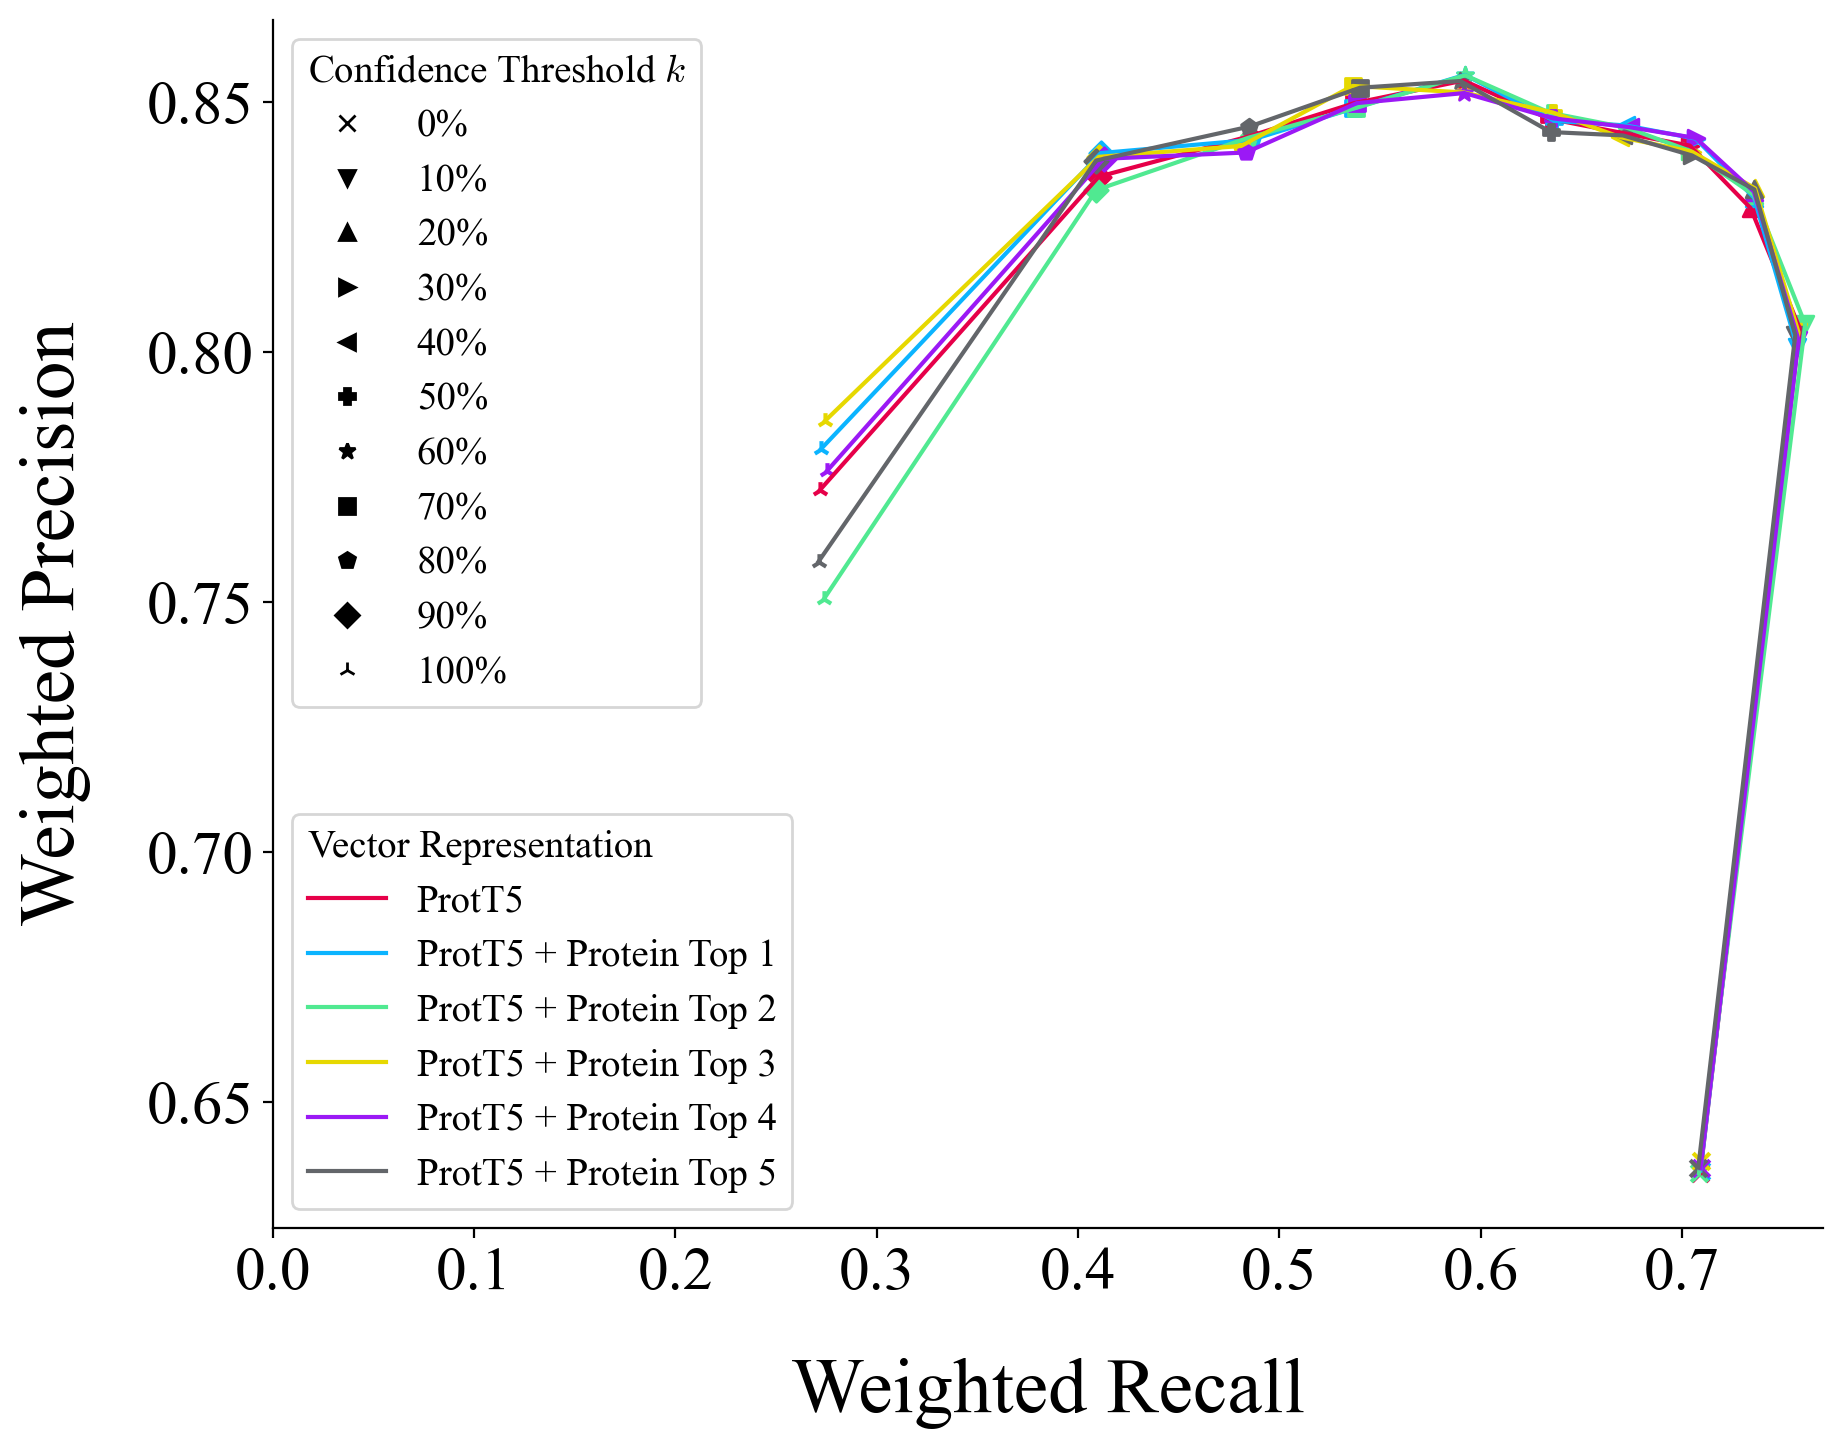

In [38]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
fig, ax = plt.subplots(figsize=(10,8), dpi=200)

line0, = ax.plot(results_recall[0], results_precision[0], color = colors[0], label = 'ProtT5')
line1, = ax.plot(results_recall[1], results_precision[1], color = colors[1], label = 'ProtT5 + Protein Top 1')
line2, = ax.plot(results_recall[2], results_precision[2], color = colors[2], label = 'ProtT5 + Protein Top 2')
line3, = ax.plot(results_recall[3], results_precision[3], color = colors[3], label = 'ProtT5 + Protein Top 3')
line4, = ax.plot(results_recall[4], results_precision[4], color = colors[4], label = 'ProtT5 + Protein Top 4')
line5, = ax.plot(results_recall[5], results_precision[5], color = colors[5], label = 'ProtT5 + Protein Top 5')

for i in range(0, 6):
    for j in range(0, 11):
        ax.scatter(results_recall[i][j], results_precision[i][j], color = colors[i], marker = markers[j])

ax.set_xlim(xmin=0, xmax=0.77)
ax.set_ylabel('Weighted Precision', labelpad = 20, fontsize = 28)
ax.set_xlabel('Weighted Recall', labelpad = 20, fontsize = 28)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
legend1 = ax.legend(loc = 'lower left', 
                    handles = [line0, line1, line2, line3, line4, line5],
                    prop={'size': 14},
                    title = 'Vector Representation')
legend2 = ax.legend(loc = 'upper left', 
                    handles = marker_handles,
                    prop={'size': 14},
                    title = 'Confidence Threshold $k$')

legend1._legend_box.align = "left"
legend2._legend_box.align = "left"
plt.gca().add_artist(legend1)